In [59]:
# Making Necessary Imports
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import norm, multinomial
from math import sqrt, log, exp, pi
import pickle

In [60]:
# Importing the dataset
galaxies = pd.read_csv("galaxies.csv")
galaxies['x'] = galaxies['x']/1000
velocities = galaxies['x'].tolist()

In [61]:
#Calculate the density corresponding to each datapoint
def calculate_ys(data, pi_k, mu_k, sigma_k, K):
    ys = []
    for i in range(len(data)):
        sum = 0
        for k in range(K):
            sum = sum + pi_k[k]*norm.pdf(data[i], mu_k[k], sigma_k)
        ys.append(sum)
    return ys

In [62]:
# Function to calculate pi_i_k
def calculate_pi_ik(data, pi_k, mu_k, sigma_k, K):
    pi_i_k = np.zeros((len(data), K))
    for i in range(len(data)):
        for k in range(K):
            numerator = pi_k[k]*norm.pdf(data[i], mu_k[k], sigma_k)
            denominator = 0
            for j in range(K):
                denominator = denominator + pi_k[j]*norm.pdf(data[i], mu_k[j], sigma_k)
            pi_i_k[i][k] = numerator/denominator
    return pi_i_k

In [63]:
#Calculate the zs (label values)
def calculate_z(data, pi_k, mu_k, sigma_k, K):
    zi = []
    pi_i_k = calculate_pi_ik(data, pi_k, mu_k, sigma_k, K)
    for i in range(len(data)):
        zi.append(np.random.multinomial(1, pi_i_k[i:][0]))
    return zi

In [66]:
# Calculate the likelihood value
def calculate_q(data, pi_k, mu_k, sigma_k, K):
    zi = calculate_z(data, pi_k, mu_k, sigma_k, K)
    sum = 0
    for i in range(len(data)):
        t = np.where(zi[i] == 1)[0][0]
        sum = sum + (-0.5*log(sigma_k**2) - ((data[i] - mu_k[t])**2)/(2*sigma_k**2) + log(pi_k[t]))
    return sum

In [67]:
#Update pi_k
def update_pi_k(data, pi_k, mu_k, sigma_k, K):

    zi = calculate_z(data, pi_k, mu_k, sigma_k, K)
    pi_k = []
    for k in range(K):
        numerator = 0
        for i in range(len(zi)):
            if(zi[i][k] == 1):
                numerator = numerator + 1
        pi_k.append(numerator/len(data))
    return pi_k           

In [68]:
# Update mu_k
def update_mu_k(data, pi_k, mu_k, sigma_k, K):
    
    zi = calculate_z(data, pi_k, mu_k, sigma_k, K)
    mu_k = []
    for k in range(K):
        numerator = 0
        denominator = 0
        for i in range(len(zi)):
            if(zi[i][k] == 1):
                numerator = numerator + data[i]
                denominator = denominator + 1
        if(denominator == 0): denominator += 1
        mu_k.append(numerator/denominator)
    return mu_k             


In [69]:
# Update sigma_k
def update_sigma(data, pi_k, mu_k, sigma_k, K):
    sigma_new = 0
    zi = calculate_z(data, pi_k, mu_k, sigma_k, K)
    for i in range(len(data)):
        for k in range(K):
            if(zi[i][k] == 1):
                sigma_new = sigma_new + ((1/len(data))*(data[i] - mu_k[k])**2)
    return sigma_new

In [70]:
# Stochastic EM Algorithm
def st_em_algorithm(data, K):
    
    pi_old = [np.random.uniform(0, 1) for _ in range(K)]
    pi_old = np.asarray(pi_old)
    pi_old = pi_old/np.sum(pi_old)
    pi_old = pi_old.tolist()

    mu_old = [np.random.uniform(1, 50) for _ in range(K)]
    sigma_old = np.random.uniform(1, 10)

    q_old = calculate_q(data, pi_old, mu_old, pow(sigma_old, 0.5), K)
    q_new = 0
    pi_new = 0
    mu_new = 0
    sigma_new = 0

    count = 0

    # E Step
    while(abs(q_new - q_old) >= 10e-3 and count <= 100):

        # M Step
        if(count <= 20):
            pi_new = update_pi_k(data, pi_old, mu_old, pow(sigma_old, 0.5), K)
            mu_new = mu_old
            sigma_new = update_sigma(data, pi_new, mu_new, pow(sigma_old, 0.5), K)
        else:
            pi_new = update_pi_k(data, pi_old, mu_old, pow(sigma_old, 0.5), K)
            mu_new = update_mu_k(data, pi_new, mu_old, pow(sigma_old, 0.5), K)
            sigma_new = update_sigma(data, pi_new, mu_new, pow(sigma_old, 0.5), K)

        q_old = q_new
        q_new = calculate_q(data, pi_new, mu_new, pow(sigma_new, 0.5), K)

        pi_old = pi_new
        sigma_old = sigma_new
        mu_old = mu_new

        count += 1
        if(count % 10 == 0):
            print("Iteration " + str(count) + ": q_new = " + str(q_new))

    return pi_new, mu_new, pow(sigma_new, 0.5)

In [71]:
parameters3 = st_em_algorithm(velocities, 3)

In [72]:
parameters4 = st_em_algorithm(velocities, 4)

Iteration 10: q_new = -195.13812679898223
Iteration 20: q_new = -174.93601407315688


In [73]:
parameters5 = st_em_algorithm(velocities, 5)

Iteration 10: q_new = -234.71156631591214


In [74]:
parameters6 = st_em_algorithm(velocities, 6)

Iteration 10: q_new = -255.79975615731294
Iteration 20: q_new = -250.55938817397447
Iteration 30: q_new = -208.90860802936703
Iteration 40: q_new = -200.24505105206745
Iteration 50: q_new = -174.80234308964813
Iteration 60: q_new = -155.17198232172422


In [75]:
parameters7 = st_em_algorithm(velocities, 7)

Iteration 10: q_new = -216.7320915316561
Iteration 20: q_new = -220.81589061289523


In [76]:
parameters8 = st_em_algorithm(velocities, 8)

Iteration 10: q_new = -177.6645795301497
Iteration 20: q_new = -179.94552414980706
Iteration 30: q_new = -144.56764408183713
Iteration 40: q_new = -153.48530677264685
Iteration 50: q_new = -141.72085964240046
Iteration 60: q_new = -153.61711564272144
Iteration 70: q_new = -157.97211786452849
Iteration 80: q_new = -146.8325453378607
Iteration 90: q_new = -147.73341544809014
Iteration 100: q_new = -149.77867087594137


In [77]:
# Calculating the parameters
parameters = [parameters3, parameters4, parameters5, parameters6, parameters7, parameters8]

In [78]:
# Function to plot the values one-shot

def calculate_vals_for_plot(data, values):
    k_vals = [3,4,5,6,7,8]
    new_ys_k = []
    for k,value in zip(k_vals, values):
        new_ys_k.append(calculate_ys(data, value[0], value[1], value[2], k))
    return new_ys_k

def plotter(new_ys_k, data):

    fig, ax = plt.subplots(nrows=3, ncols=2, figsize = (15,15))
    x_values = np.linspace(start = 0, stop = 35, num = 1000)
    
    ax[0,0].hist(data, density = True, bins = 25, label='Histogram of velocities')
    ax[0,0].plot(x_values, new_ys_k[0], label = 'Fitted curve')
    ax[0,0].set_title('Fitted Normal Location Scale Mixture Model with K = 3')
    ax[0,0].set_xlabel('Velocities')
    ax[0,0].set_ylabel('Density')
    ax[0,0].legend(loc = 'upper right')

    ax[0,1].hist(data, density = True, bins = 25, label='Histogram of velocities')
    ax[0,1].plot(x_values, new_ys_k[1], label = 'Fitted curve')
    ax[0,1].set_title('Fitted Normal Location Scale Mixture Model with K = 4')
    ax[0,1].set_xlabel('Velocities')
    ax[0,1].set_ylabel('Density')
    ax[0,1].legend(loc = 'upper right')

    ax[1,0].hist(data, density = True, bins = 25, label='Histogram of velocities')
    ax[1,0].plot(x_values, new_ys_k[2], label = 'Fitted curve')
    ax[1,0].set_title('Fitted Normal Location Scale Mixture Model with K = 5')
    ax[1,0].set_xlabel('Velocities')
    ax[1,0].set_ylabel('Density')
    ax[1,0].legend(loc = 'upper right')

    ax[1,1].hist(data, density = True, bins = 25, label='Histogram of velocities')
    ax[1,1].plot(x_values, new_ys_k[3], label = 'Fitted curve')
    ax[1,1].set_title('Fitted Normal Location Scale Mixture Model with K = 6')
    ax[1,1].set_xlabel('Velocities')
    ax[1,1].set_ylabel('Density')
    ax[1,1].legend(loc = 'upper right')

    ax[2,0].hist(data, density = True, bins = 25, label='Histogram of velocities')
    ax[2,0].plot(x_values, new_ys_k[4], label = 'Fitted curve')
    ax[2,0].set_title('Fitted Normal Location Scale Mixture Model with K = 7')
    ax[2,0].set_xlabel('Velocities')
    ax[2,0].set_ylabel('Density')
    ax[2,0].legend(loc = 'upper right')

    ax[2,1].hist(data, density = True, bins = 25, label='Histogram of velocities')
    ax[2,1].plot(x_values, new_ys_k[5], label = 'Fitted curve')
    ax[2,1].set_title('Fitted Normal Location Scale Mixture Model with K = 8')
    ax[2,1].set_xlabel('Velocities')
    ax[2,1].set_ylabel('Density')
    ax[2,1].legend(loc = 'upper right')

In [79]:
with open('updated_parameters_5b_2.pickle', 'wb') as file:
    pickle.dump(parameters, file)

In [80]:
parameters2 = None
with open('updated_parameters_5b_2.pickle', 'rb') as file:
    parameters2 = pickle.load(file)

In [81]:
x = np.linspace(start = 0, stop = 35, num = 1000).tolist()
new_y_values = calculate_vals_for_plot(x, parameters)

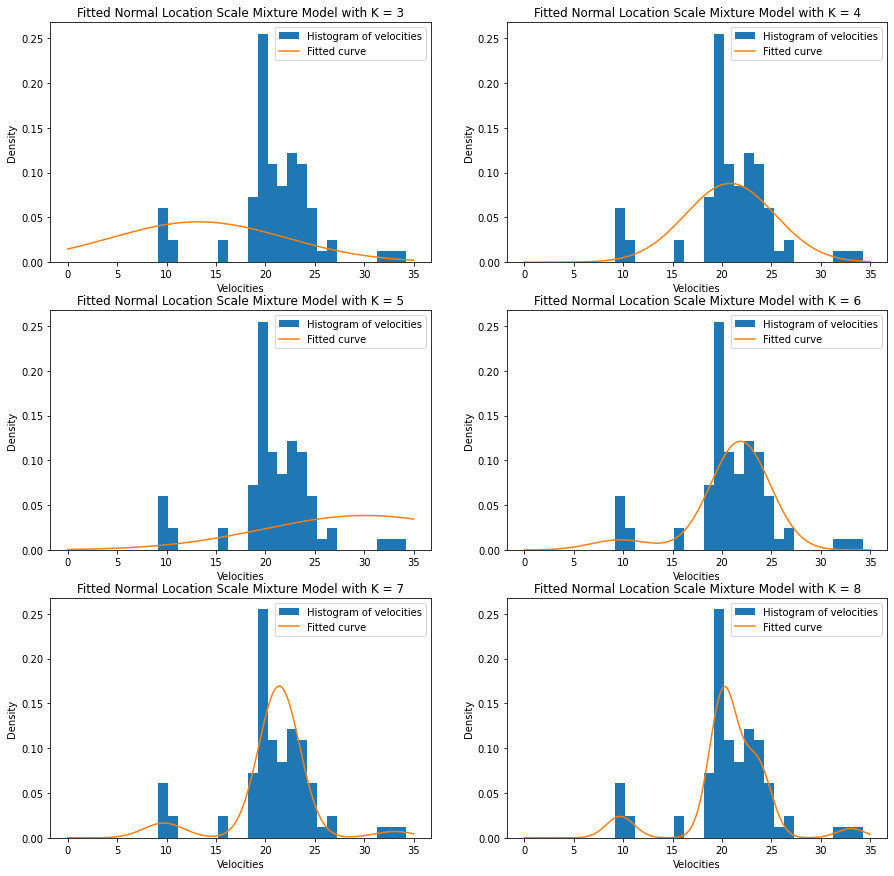

In [82]:
plotter(new_y_values, velocities)

In [83]:
# Calculate AIC
def calculate_aic(data, parameters):
    aic_k = []
    k_vals = [3,4,5,6,7,8]
    k_indicator = 0 
    for param in parameters:
        vals =  2*(-1*calculate_q(data, param[0], param[1], param[2], k_vals[k_indicator]) + k_vals[k_indicator])
        aic_k.append(vals)
        k_indicator +=1    
    return aic_k

In [84]:
aic_k = calculate_aic(velocities, parameters2)

In [85]:
aic_k

[445.592073517817,
 337.969862945876,
 475.3588669056884,
 322.34396464344843,
 288.1514964613857,
 312.3150580081916]

In [86]:
# Calculate BIC

def calculate_bic(data, parameters):
    bic_k = []
    k_vals = [3,4,5,6,7,8]
    k_indicator = 0 
    for param in parameters:
        vals =  -2*calculate_q(data, param[0], param[1], param[2], k_vals[k_indicator]) + k_vals[k_indicator]*log(len(data))
        bic_k.append(vals)
        k_indicator +=1    
    return bic_k

In [87]:
bic_k = calculate_bic(velocities, parameters2)
bic_k

[452.8122312596098,
 347.596739934933,
 487.39246314200966,
 336.784280127034,
 312.5526698778936,
 346.4431622586945]